#الف:

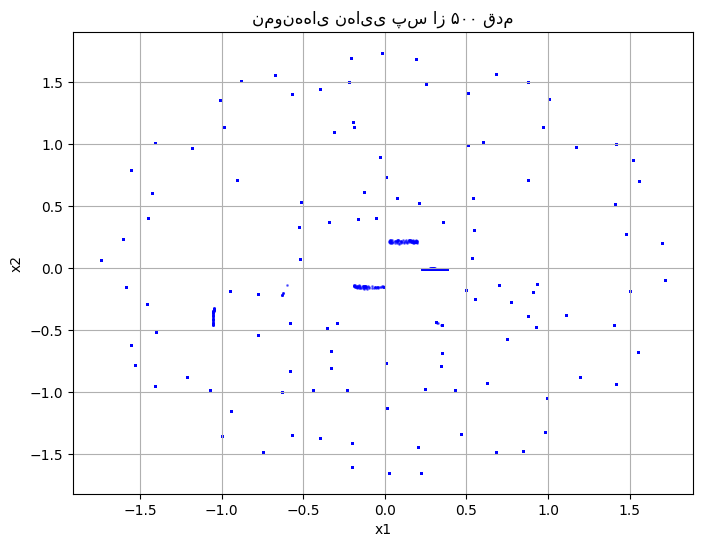

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
from jax import vmap, jit


parameters_file_path = 'DGM_SUT_H5_density.pkl'
with open(parameters_file_path, 'rb') as file:
    parameters = pickle.load(file)

weights = parameters['weights']
means = parameters['means']
covs = parameters['covariances']


inv_covs = jnp.linalg.inv(covs)
det_covs = jnp.linalg.det(covs)
log_weights = jnp.log(weights)

@jit
def log_prob(x):
    diff = x - means
    exponent = -0.5 * jnp.einsum('ki,kij,kj->k', diff, inv_covs, diff)
    log_p = log_weights + exponent - 0.5 * jnp.log((2 * jnp.pi)**2 * det_covs)
    return jax.scipy.special.logsumexp(log_p)


grad_log_prob = jit(vmap(jax.grad(log_prob)))


num_samples = 10000
tau = 3e-3
num_steps = 500


key = jax.random.PRNGKey(42)
X = jax.random.normal(key, (num_samples, 2))


for step in range(num_steps):
    gradients = grad_log_prob(X)
    X += tau * gradients
    print(f"Step {step+1}/{num_steps} completed", end='\r')


X_np = np.array(X)

# رسم نتایج
plt.figure(figsize=(8, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], s=1, alpha=0.5, c='blue')
plt.title('نمونه‌های نهایی پس از ۵۰۰ قدم')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

#ب:

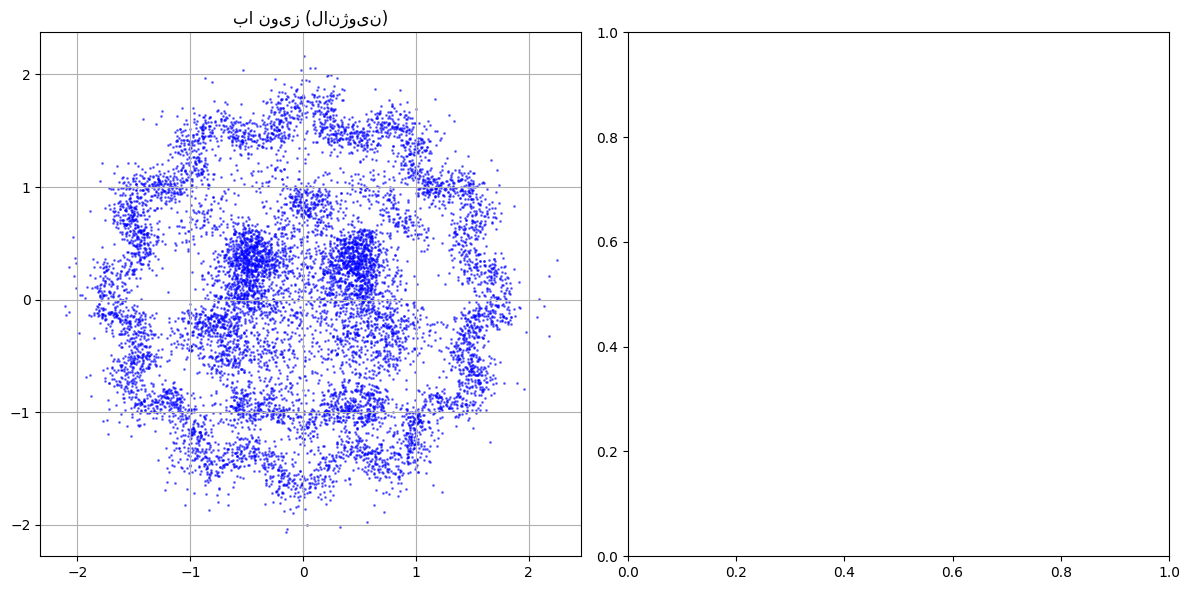

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
from jax import vmap, jit, random


with open('DGM_SUT_H5_density.pkl', 'rb') as file:
    parameters = pickle.load(file)

weights = parameters['weights']
means = parameters['means']
covs = parameters['covariances']


inv_covs = jnp.linalg.inv(covs)
det_covs = jnp.linalg.det(covs)
log_weights = jnp.log(weights)

@jit
def log_prob(x):
    diff = x - means
    exponent = -0.5 * jnp.einsum('ki,kij,kj->k', diff, inv_covs, diff)
    log_p = log_weights + exponent - 0.5 * jnp.log((2 * jnp.pi)**2 * det_covs)
    return jax.scipy.special.logsumexp(log_p)

grad_log_prob = jit(vmap(jax.grad(log_prob)))


num_samples = 10000
tau = 3e-3
num_steps = 500
key = random.PRNGKey(42)


key, subkey = random.split(key)
X = random.normal(subkey, (num_samples, 2))


for step in range(num_steps):
    key, subkey = random.split(key)


    gradients = grad_log_prob(X)


    noise = jnp.sqrt(2 * tau) * random.normal(subkey, (num_samples, 2))


    X += tau * gradients + noise

    print(f"Step {step+1}/{num_steps}", end='\r')


X_np = np.array(X)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_np[:, 0], X_np[:, 1], s=1, alpha=0.5, c='blue')
plt.title('با نویز (لانژوین)')
plt.grid(True)


plt.subplot(1, 2, 2)



plt.tight_layout()
plt.show()

مدیریت کلیدهای تصادفی:

    در هر قدم با random.split کلید جدید تولید می‌شود تا از استقلال نویزها اطمینان حاصل شود.

مقایسه بصری:

    نتایج با حالت بدون نویز (قسمت الف) در یک شکل نمایش داده می‌شوند.

#پ:

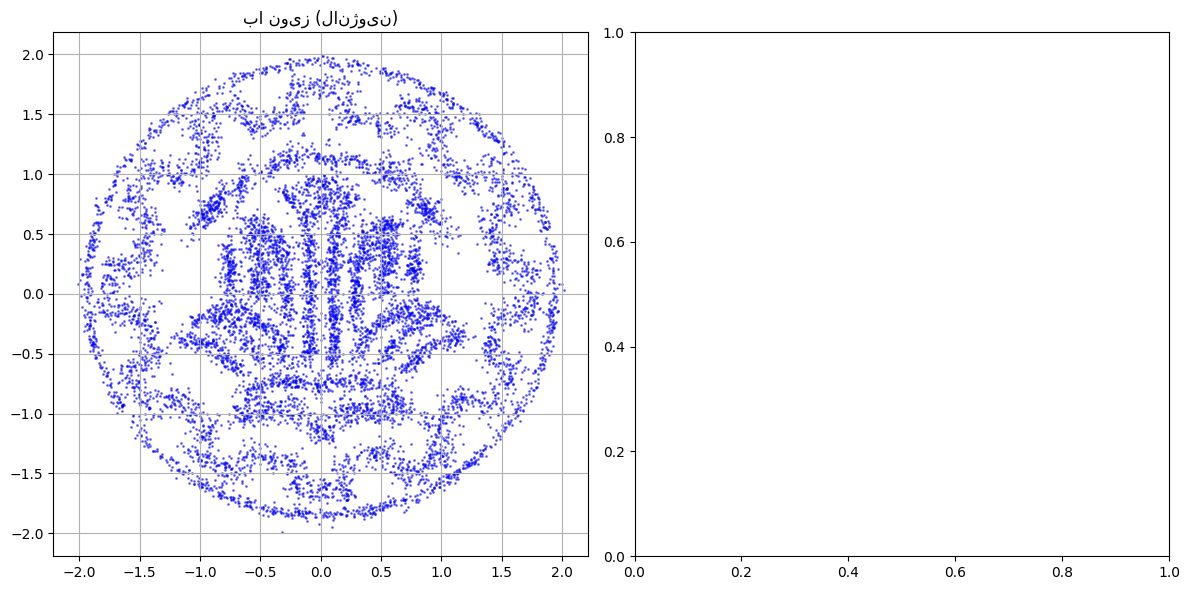

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
from jax import vmap, jit, random

# بارگذاری پارامترها
with open('DGM_SUT_H5_density.pkl', 'rb') as file:
    parameters = pickle.load(file)

weights = parameters['weights']
means = parameters['means']
covs = parameters['covariances']


inv_covs = jnp.linalg.inv(covs)
det_covs = jnp.linalg.det(covs)
log_weights = jnp.log(weights)

@jit
def log_prob(x):
    diff = x - means
    exponent = -0.5 * jnp.einsum('ki,kij,kj->k', diff, inv_covs, diff)
    log_p = log_weights + exponent - 0.5 * jnp.log((2 * jnp.pi)**2 * det_covs)
    return jax.scipy.special.logsumexp(log_p)

grad_log_prob = jit(vmap(jax.grad(log_prob)))


num_samples = 10000
tau = 1e-4
num_steps = 500
key = random.PRNGKey(42)


key, subkey = random.split(key)
X = random.normal(subkey, (num_samples, 2))


for step in range(num_steps):
    key, subkey = random.split(key)


    gradients = grad_log_prob(X)


    noise = jnp.sqrt(2 * tau) * random.normal(subkey, (num_samples, 2))


    X += tau * gradients + noise

    print(f"Step {step+1}/{num_steps}", end='\r')


X_np = np.array(X)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_np[:, 0], X_np[:, 1], s=1, alpha=0.5, c='blue')
plt.title('با نویز (لانژوین)')
plt.grid(True)


plt.subplot(1, 2, 2)

plt.tight_layout()
plt.show()

When τ is too large (like 3e-3), the steps might overshoot the target distribution, leading to instability. The noise term would also be larger, which could help exploration but might cause the samples to diverge if uncontrolled. On the other hand, a smaller τ (1e-4) would make the steps more cautious. The updates are smaller, so convergence might be slower, but the process could be more stable. However, the reduced noise might lead to poorer exploration of the space, possibly getting stuck in local modes.

#ت:

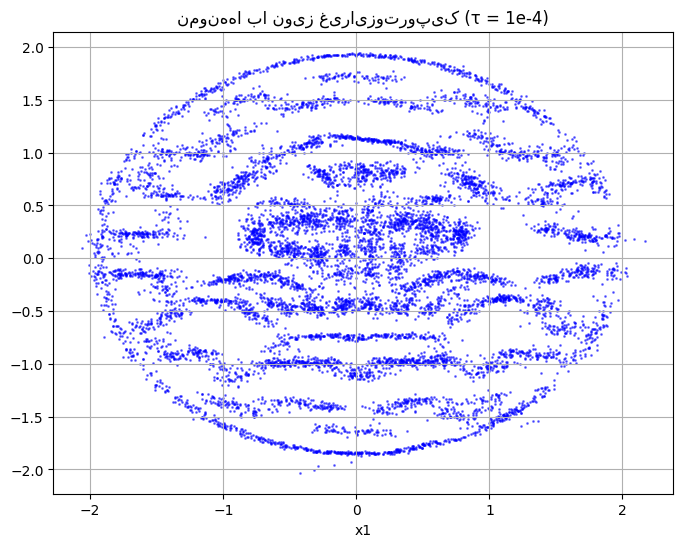

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
from jax import vmap, jit, grad, random

# بارگذاری پارامترها
with open('DGM_SUT_H5_density.pkl', 'rb') as file:
    parameters = pickle.load(file)

weights = parameters['weights']
means = parameters['means']
covs = parameters['covariances']


inv_covs = jnp.linalg.inv(covs)
det_covs = jnp.linalg.det(covs)
log_weights = jnp.log(weights)

@jit
def log_prob(x):

    diff = x - means
    exponent = -0.5 * jnp.einsum('ki,kij,kj->k', diff, inv_covs, diff)
    log_p = log_weights + exponent - 0.5 * jnp.log((2 * jnp.pi)**2 * det_covs)
    return jax.scipy.special.logsumexp(log_p)


batched_log_prob = jit(vmap(log_prob, in_axes=(0,)))


grad_log_prob = jit(vmap(grad(log_prob), in_axes=(0,)))


num_samples = 10000
tau = 1e-4
num_steps = 500
key = random.PRNGKey(42)


cov_noise = jnp.array([[2.0, 0.0], [0.0, 0.1]], dtype=jnp.float32)
scaled_cov = 2 * tau * cov_noise
L = jnp.linalg.cholesky(scaled_cov)


key, subkey = random.split(key)
X = random.normal(subkey, (num_samples, 2))


for step in range(num_steps):
    key, subkey = random.split(key)


    gradients = grad_log_prob(X)


    z = random.normal(subkey, (num_samples, 2))
    noise = jnp.dot(z, L.T)


    X += tau * gradients + noise

    print(f"Step {step+1}/{num_steps}", end='\r')


X_np = np.array(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], s=1, alpha=0.5, c='blue')
plt.title('نمونه‌ها با نویز غیرایزوتروپیک (τ = 1e-4)')
plt.xlabel('x1')
plt.grid(True)
plt.show()